## Compressed sensing with QFT

**Compressed sensing objective**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D}$ we want to find a vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } C\mathbf{x} = CF^{-1}\mathbf{s}
$$


**Tensorized extension of compressed sensing**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D\times\cdots\times D}$ represented in TT format with ranks $\{R_i\}_{i=1}^N$ we want to find a TT-vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } \mathcal{C}\mathcal{x} = \mathcal{C}\mathcal{F}^{-1}\mathcal{s}
$$

where $\mathcal{C}\,\&\,\mathcal{F}$ are Matrix Product Operators (MPO).


In [ ]:
# Install packages
!pip install quimb 

In [151]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from scipy.optimize import minimize
from math import sqrt

# =======================================================
# (Example 1) Standard Constrained Optimization in NumPy
# =======================================================

# def f(x):
#     print(x)
#     return sqrt(0.1*x[0]*x[1])

# def ineq_constraint(x):
#     return x[0] - x[1]

# con = {'type': 'ineq', 'fun': ineq_constraint}

# x0 = [1, 1]
# res = minimize(f, x0, method='SLSQP', constraints=con, bounds=[(0, None) for i in range(len(x0))], options={'disp': True, 'iprint': 2})


# ===============================================
# (Example 2) Simple MPS constrained optimization
# ===============================================

# def f(x, H, R, D, verbose=False):
#     # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
#     x = x.reshape(H, R, R, D)

#     # Each MPS core is of shape (Rl, Rr, D)
#     arrays = [x[0][0:1, ...]] + [x[i] for i in range(1, H-1)] + [x[H-1][..., 0:1, :]]
#     if verbose:
#         print('\n'.join(str(a.shape) for a in arrays))

#     # Create the MPS
#     mps = qtn.MatrixProductState(arrays)
#     return mps.norm()


# H, R, D = 8, 2, 2
# con = [{'type': 'ineq', 'fun': lambda x, idx=i: (x[idx] - 0.5)} for i in range(H*R*R*D)]

# x0 = np.random.rand(H*R*R*D)
# res = minimize(f, x0, method='SLSQP', constraints=con, args=(H, R, D), options={'disp': True, 'iprint': 2})


# ================================================
# (Main) MPS compressed sensing (Example 3)
# ================================================

def obj_fn(x, L, R, D, verbose=False):
    # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
    x = x.reshape(L, R, R, D)

    # Each MPS core is of shape (Rl, Rr, D)
    arrays = [x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :]]
    if verbose:
        print('\n'.join(str(a.shape) for a in arrays))

    # Create the MPS
    mps = qtn.MatrixProductState(arrays)
    return mps.norm()  # should make l1 norm

def vec2mps(x, L, R, D) -> qtn.MatrixProductState:
     x = x.reshape(L, R, R, D)
     return qtn.MatrixProductState([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :]])

def vec2mpo(x, L, R, D) -> qtn.MatrixProductOperator:
     x = x.reshape(L, R, R, D, D)
     return qtn.MatrixProductOperator([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :, :]])


L, R, D = 8, 2, 4

# Create MPO transforms
c = np.random.rand(L, R, R, D, D)  # sampler MPO
finv = np.random.rand(L, R, R, D, D)  # inverse fourier MPO
c_mpo = qtn.MatrixProductOperator([c[0][0:1, ...]] + [c[i] for i in range(1, L-1)] + [c[L-1][..., 0:1, :, :]])
finv_mpo = qtn.MatrixProductOperator([finv[0][0:1, ...]] + [finv[i] for i in range(1, L-1)] + [finv[L-1][..., 0:1, :, :]])
w_mpo = c_mpo.apply(finv_mpo)  # combined MPO


# Original signal
x_targ_mps = qtn.MPS_rand_state(L=L, bond_dim=R, phys_dim=D)  # dense tensor
y_mps = -1*c_mpo.apply(x_targ_mps)

con = []
# i.e. y - CFs = 0
con.append({'type': 'eq', 'fun': lambda s_t: (vec2mps(s_t, L, R, D) + y_mps).norm()})

x0 = np.random.rand(L*R*R*D)
res = minimize(obj_fn, x0, method='SLSQP', constraints=con, args=(L, R, D), options={'disp': True, 'iprint': 2})

  NIT    FC           OBJFUN            GNORM
    1   130     2.863891E+03     2.354458E+02
    2   261     9.826276E+11     2.275643E+02
    3   393     7.496815E+04     2.237826E+02
    4   523     8.358611E+06     2.122098E+02
    5   654     2.889465E+04     2.112465E+02
    6   784     1.144532E+06     2.191635E+02
    7   915     3.105929E+05     2.218957E+02
    8  1046     3.412982E+02     1.956956E+02
    9  1176     4.381356E+01     1.562876E+02
   10  1305     1.755466E+02     8.793191E+01
   11  1435     3.575347E+04     6.179799E+01
   12  1565     4.054971E+05     5.975485E+01
   13  1696     3.625379E+05     4.281262E+01
   14  1827     4.644892E+08     5.199074E+01
   15  1958     3.018967E+06     5.730598E+01
   16  2089     2.357437E+04     6.486614E+01
   17  2220     2.467754E+05     7.882303E+01
   18  2352     1.947958E+05     8.042388E+01
   19  2482     1.320963E+10     2.177184E+01
   20  2613     1.174919E+10     3.296017E+01
   21  2744     6.044106E+18     5

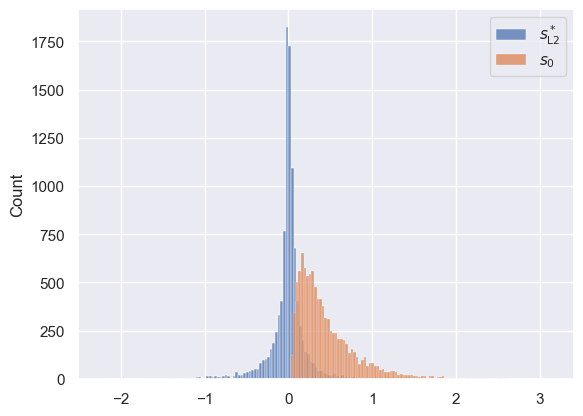

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt


def random_samples_with_amplitudes(mps, num_samples=5):
    L = mps.L
    d = mps.phys_dim()
    results = []

    for _ in range(num_samples):
        # uniformly random configuration
        cfg = np.random.randint(0, d, size=L)
        mapping = {mps.site_ind(i): int(cfg[i]) for i in range(L)}

        # contract to get amplitude
        amp = mps.isel(mapping).contract(output_inds=())

        results.append(amp)

    return results


samples_l2 = random_samples_with_amplitudes(vec2mps(res.x, L, R, D), num_samples=10000)
samples_random = random_samples_with_amplitudes(vec2mps(x0, L, R, D), num_samples=10000)
sns.set_theme()
sns.histplot(samples_l2, bins=100, label=r"$s^*_{\mathrm{L2}}$")
sns.histplot(samples_random, bins=100, label=r"$s_0$")
plt.legend()
plt.show()

## Misc

In [ ]:
# Define the objective function
def loss_fn(s_mps, w_mpo, x_targ_mps, lam=1):
    x_hat_mps = w_mpo.apply(other=s_mps)
    diff = x_hat_mps - x_targ_mps
    return diff.norm() + lam * s_mps.norm()


# Define the optimizer
tnopt = qtn.TNOptimizer(
    # the tensor network we want to optimize
    r,
    # the functions specfying the loss and normalization
    loss_fn=loss_fn,
    # norm_fn=norm_fn,
    # we specify constants so that the arguments can be converted
    # to the  desired autodiff backend automatically
    loss_constants={"w_mpo": w_mpo, "x_targ_mps": x_targ_mps},
    # the underlying algorithm to use for the optimization
    # 'l-bfgs-b' is the default and often good for fast initial progress
    optimizer="adam",
    # which gradient computation backend to use
    autodiff_backend="torch",
)

In [ ]:
# Optimize the tensor network
s_mps_opt = tnopt.optimize(num_steps)

# Print loss
print(f"Initial loss: {loss_fn(r, w_mpo, x_targ_mps)}")
print(f"Final loss: {loss_fn(s_mps_opt, w_mpo, x_targ_mps)}")

  0%|          | 0/1000 [00:00<?, ?it/s]

+1.000363682768 [best: +1.000359814891] : : 1001it [00:04, 213.63it/s]                        


Initial loss: 2.00333825261809
Final loss: 1.0003636827681783


In [50]:
import numpy as np

def random_samples_with_amplitudes(mps, num_samples=5):
    L = mps.L
    d = mps.phys_dim()
    results = []

    for _ in range(num_samples):
        # uniformly random configuration
        cfg = np.random.randint(0, d, size=L)
        mapping = {mps.site_ind(i): int(cfg[i]) for i in range(L)}

        # contract to get amplitude
        amp = mps.isel(mapping).contract(output_inds=())

        results.append({
            'indices': cfg.tolist(),
            'amplitude': amp
        })

    return results


# example usage
samples_l1 = random_samples_with_amplitudes(s_mps_opt, num_samples=10000)


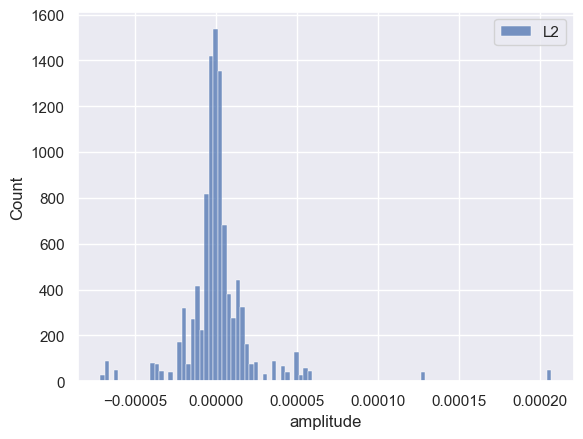

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(samples_l1)

sns.set_theme()

sns.histplot(df["amplitude"], bins=100, label="L2")
plt.legend()
plt.show()